In [1]:
import math
import random

### GreedyE ###

def nextblock(num,w,k,kmer): #auxiliary#    first int>=num such that its bitstring of len w+k contains bitstring of kmer
    pos = 2**(w+k)
    mask = 2**k-1
    depth = w+k
    for i in range(w+1):
        cur = (num>>(w-i)) & mask
        if cur < kmer:
            temp = ((num>>(w-i)) + kmer - cur)<<(w-i)
        elif cur > kmer:
            temp = ((num>>(w-i)) + kmer + 2**k - cur)<<(w-i)
        else:
            return num, i
        if temp < pos:
            pos = temp
            depth = i
    return pos, depth

def initdfs(kmer,kmers,lev,w,k): #auxiliary#    recursively compute initial values of global arrays nongc[] and gc[]
    flag = kmer not in kmers
    if lev == w:
        if flag:
            gc[kmer] += 1
    else:
        if flag:
            nongc[kmer] += 2**(w-lev)
            kmers.add(kmer)
        nextkmer = (kmer<<1) & (2**k-1)
        initdfs(nextkmer,kmers,lev+1,w,k)
        initdfs(nextkmer+1,kmers,lev+1,w,k)
        if flag:
            kmers.remove(kmer)

def rightdfs(kmer,kmers,lev,w,k): #auxiliary#   recursively process a block of occurrences of kmer 
    if nongc[kmer] == 0 and gc[kmer] == 0: # kmer has earlier assigned rank, or current rank, but all unprocessed windows are dead
        return 0
    else:
        flag = kmer not in kmers
        if lev == w:
            gc[kmer] -= flag
            return 1
        else:
            if flag:
                kmers.add(kmer)
            nextkmer = (kmer<<1) & (2**k-1)
            sub = rightdfs(nextkmer,kmers,lev+1,w,k) + rightdfs(nextkmer+1,kmers,lev+1,w,k)
            if flag:
                if lev>0:
                    nongc[kmer] -= sub
                else:
                    gc[kmer] -= sub
                kmers.remove(kmer)
            return sub
          
def randcand(k,err): #auxiliary#    choose a random k-mer with best nongc/gc ratio up to multiplicative err
    best_ratio = -1
    for i in range(2**k):
        if gc[i]==0:
            if nongc[i]>0:
                return i
        else:
            best_ratio = max(nongc[i]/gc[i], best_ratio)
    if best_ratio>=0:
        candidates = [i for i in range(2**k) if gc[i]>0 and nongc[i] >= gc[i]*best_ratio*err]
        return random.choice(candidates)
    else:
        return 2**k
        
def ecogreed(w,k,err): #greedy choice of a good 2ary order in small space
    # calls initdfs, randcand, nextblock(many), rightdfs(many)
    global gc, nongc
    mask = 2**k-1
    gc = [0 for i in range(2**k)]
    nongc = [0 for i in range(2**k)]
    ans = [2**k for i in range(2**k)]
    for pref in range(2**k): #fill the arrays gc and nongc
        gc[pref] += 2**w
        kmers = {pref}
        k1 = (pref<<1) & mask
        initdfs(k1, kmers,1,w,k)
        initdfs(k1+1, kmers,1,w,k)
    gc_count = 0
    nextbest = randcand(k,err) #choice of the rank0 kmer
    rank = 0
    while nextbest < 2**k: #main cycle (updating gc and nongc by processing windows with nextbest
        gc_count += gc[nextbest]
        ans[nextbest] = rank
        block, dep = nextblock(0,w,k,nextbest) #first block of occurrences of nextbest
        while block < 2**(w+k): #internal loop over the blocks of occurrences of nextbest
            kmers = set()
            skip = False
            for i in range(dep): # processing left kmers of nextbest
                leftkmer = (block>>(w-i)) & mask
                skip = (ans[leftkmer]<rank)
                if skip: # smaller kmer found, block consists of dead windows
                    block,dep = nextblock(((block>>(w-i)) + 1)<<(w-i),w,k,nextbest) # increase leftkmer by 1 and find next block after
                    break
                else:
                    kmers.add(leftkmer)
            if not skip: # processing right kmers of nextbest
                subt = rightdfs(nextbest, kmers, dep, w, k)
                if kmers:
                    pref = block>>w
                    gc[pref] -= subt
                    kmers.remove(pref)
                    for km in kmers:
                        nongc[km] -= subt
                block, dep = nextblock(block+2**(w-dep),w,k,nextbest) # finding next block
        nextbest = randcand(k,err)
        rank += 1
    return ans, gc_count, rank

In [2]:
n_results = 1000

In [3]:
w=8
k=13
results = []

for _ in range(n_results):
    results.append(ecogreed(w,k,0.995)[2])


# save to file using w and k as filename
with open(f'{w}_{k}.txt', 'w') as f:
    for item in results:
        f.write("%s\n" % item)

KeyboardInterrupt: 

In [ ]:
w= 13
k=8
results = []

for _ in range(n_results):
    results.append(ecogreed(w,k,0.995)[2])

# save to file using w and k as filename
with open(f'{w}_{k}.txt', 'w') as f:
    for item in results:
        f.write("%s\n" % item)

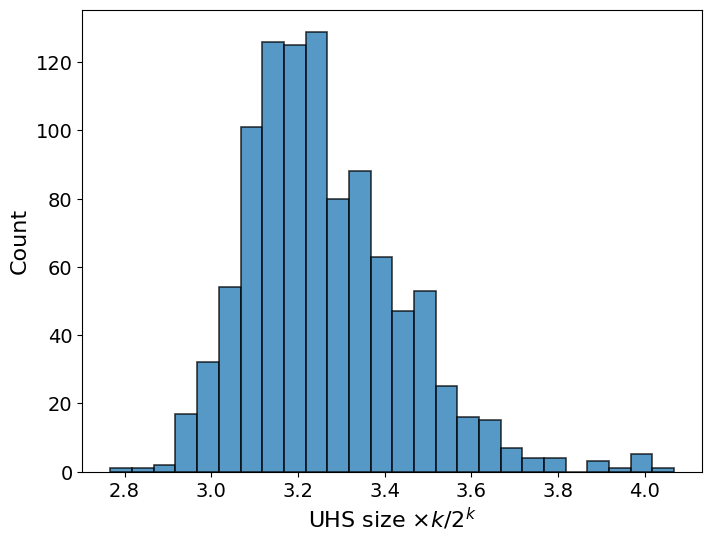

Average: 3.2618590087890627
STD: 0.18010151389727033


In [13]:
import numpy as np
import matplotlib.pyplot as plt

w = 8
k = 13

# Load results
with open(f'{w}_{k}.txt') as f:
    results = f.readlines()
    results = [int(x.strip()) for x in results]

# Normalize
normalized_results = [x / (2**k / k) for x in results]

# Define finer bins
bin_width = 0.05
bins = np.arange(min(normalized_results), max(normalized_results) + bin_width, bin_width)
plt.figure(figsize=(8, 6))
# Plot histogram
plt.hist(normalized_results, bins=bins, alpha=0.75, edgecolor='black', linewidth=1.2)
plt.xlabel(r"UHS size $\times k/2^k$", fontsize=16)

plt.ylabel("Count", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig(f'hist_{w}_{k}.svg')
#plt.title('Histogram of number of ranks for w = {} and k = {}'.format(w, k))
plt.show()


# print the average and STD
print(f'Average: {np.mean(normalized_results)}')
print(f'STD: {np.std(normalized_results)}')


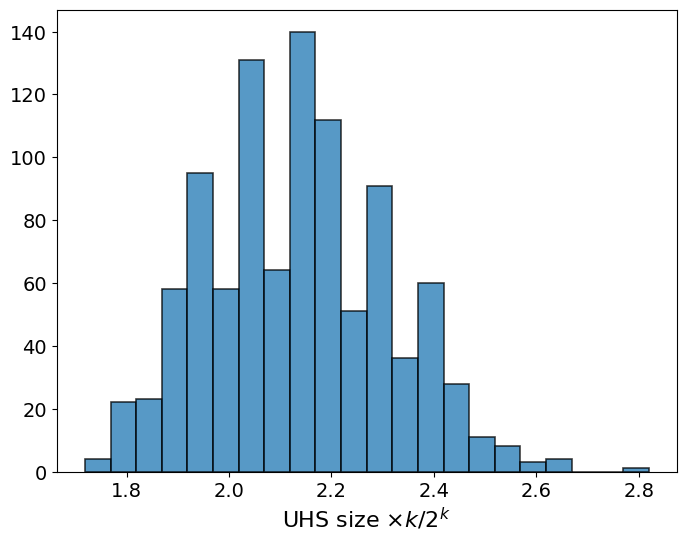

Average: 2.13784375
STD: 0.1748606560191214


In [14]:
import numpy as np
import matplotlib.pyplot as plt

w = 13
k = 8

# Load results
with open(f'{w}_{k}.txt') as f:
    results = f.readlines()
    results = [int(x.strip()) for x in results]

# Normalize
normalized_results = [x / (2**k / k) for x in results]

# Define finer bins
bin_width = 0.05
bins = np.arange(min(normalized_results), max(normalized_results) + bin_width, bin_width)

# Plot histogram
plt.figure(figsize=(8, 6))
plt.hist(normalized_results, bins=bins, alpha=0.75, edgecolor='black', linewidth=1.2)
plt.xlabel(r"UHS size $\times k/2^k$", fontsize=16)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#plt.title('Histogram of number of ranks for w = {}, k = {}'.format(w, k))
plt.savefig(f'hist_{w}_{k}.svg')
plt.show()

print(f'Average: {np.mean(normalized_results)}')
print(f'STD: {np.std(normalized_results)}')